# 카카오톡 대화 분석
## 사용자별 토픽 분석하기

## LDA 에서 Author Topic Model
출처 : M Rosen-Zvi, The Author-Topic Model for Authors and Documents, 2003
https://mimno.infosci.cornell.edu/info6150/readings/398.pdf

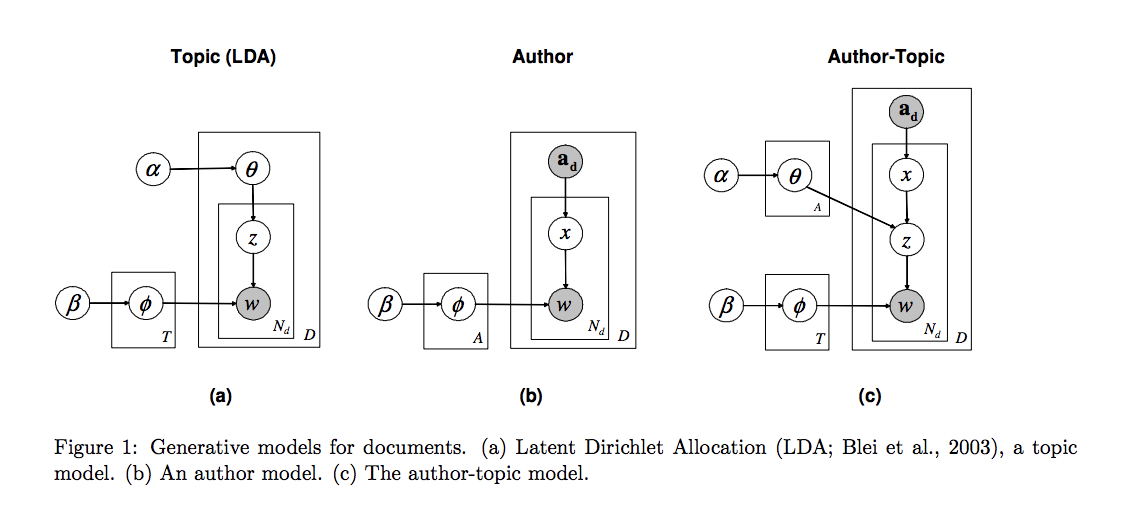


사람이 글을 쓰는 모델로 가자면 어떤 문서들이 있는데 , 저자가 다르다면 단어분포가 달라지고, 그러면 토픽도 달라지지지 않을까 라는 생각에서 나온 것이 LDA에서 확장된 ATM이다. 

간단하게, ATM = LDA + 저자 정보라고 생각하면 된다. 
문서에 저자에 대한 정보가 반영되어서 확률분포에 들어간다. 


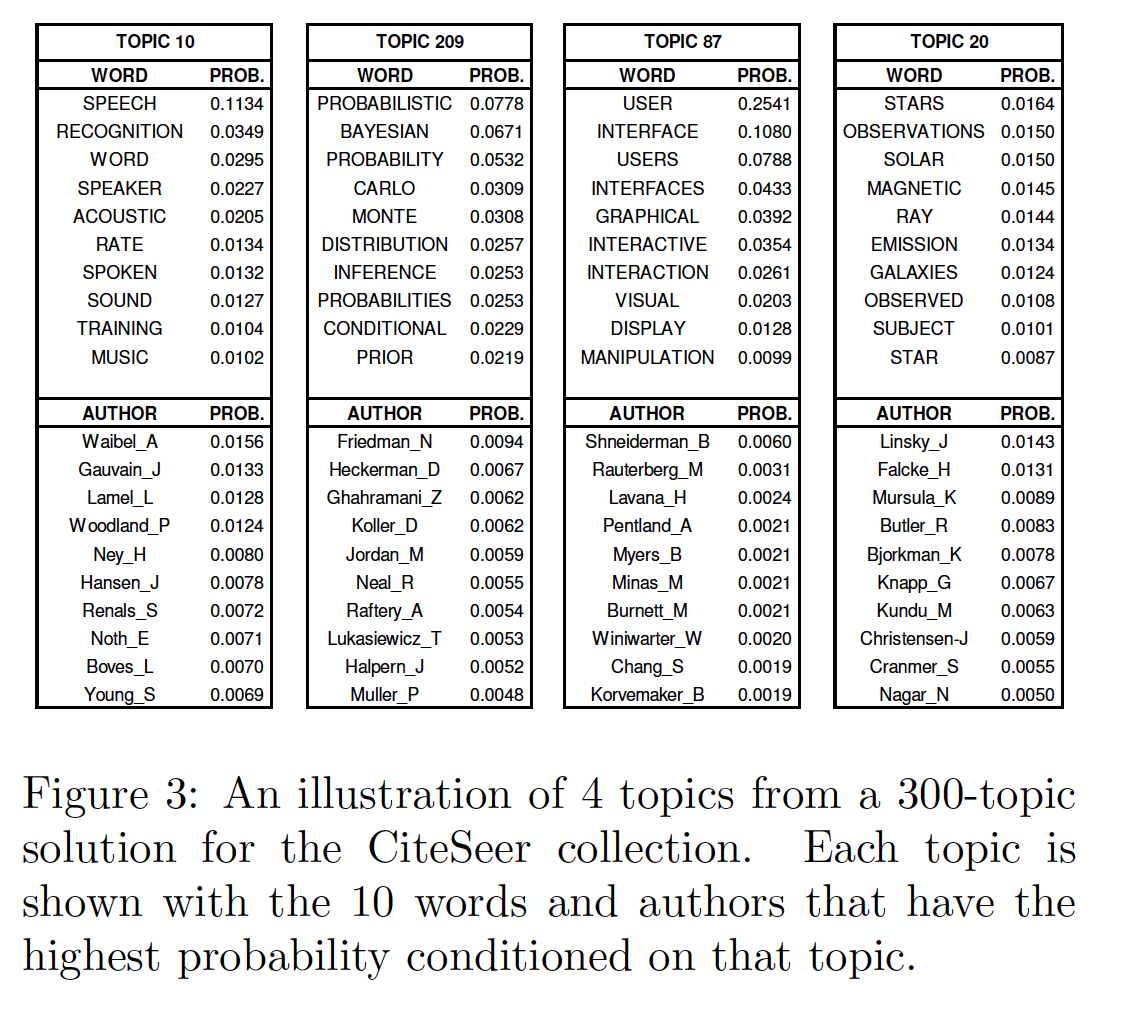

## 학습 목표
: ATM도 gensim에서 똑같이 LDA 사용했듯이 사용가능하다. 
ATM이라는 함수를 사용하기 위해서 데이터를 어떻게 처리해야하고, 
그 처리된 데이터가 ATM model로 학습이 되었을 때 어떤 결과가 나오는지 까지 살펴보도록 한다. 

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

import pickle

In [2]:
with open("data/cleaned_data.pk", "rb") as f:
    data = pickle.load(f)
    
data.reset_index(drop = True, inplace = True)
print(data.head())
print(data.info())

                  Date User                                            Message
0  2018-12-17 13:37:07  kkk                                kkk invited sss and
1  2018-12-17 13:37:07  kkk                                         삭제된 메시지입니다
2  2018-12-17 13:38:06  kkk  4시6시반 현정 서우만나서놈 6시반9시 현정 출근 \n경민 스터디 끝나구 합류\n ...
3  2018-12-17 13:38:31  sss                                                20일
4  2018-12-17 13:38:37  kkk                                                  넵
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
Date       249 non-null object
User       249 non-null object
Message    249 non-null object
dtypes: object(3)
memory usage: 6.0+ KB
None


### 1. ATM 사용을 위한 데이터 처리

In [22]:
#사용자 별로 데이터 분석을 해야 하기 때문에 사용자 정보를 가져옴
users = set(data["User"])
users

{'kkk', 'sss', '정현정'}

In [29]:
#사용자별로 데이터 묶기
authors = data.groupby("User") #user별로 묶고
pprint(authors.groups) #.groups : 인덱스별로 묶여서 출력된다. 
print(type(authors.groups))

{'kkk': Int64Index([  0,   1,   2,   4,   6,  10,  11,  14,  16,  21,  28,  33,  34,
             36,  42,  43,  44,  47,  48,  49,  56,  74,  75,  78,  89,  94,
             97, 100, 103, 109, 115, 116, 117, 123, 124, 125, 128, 129, 131,
            132, 145, 146, 147, 160, 162, 163, 164, 169, 175, 176, 177, 182,
            206, 209, 210, 211, 215, 216, 226, 227, 232, 233, 234, 236, 238,
            240, 244, 245, 246],
           dtype='int64'),
 'sss': Int64Index([  3,   5,   7,   8,   9,  12,  13,  15,  17,  18,
            ...
            230, 231, 235, 237, 239, 241, 242, 243, 247, 248],
           dtype='int64', length=114),
 '정현정': Int64Index([ 19,  20,  26,  27,  31,  32,  40,  41,  46,  51,  53,  54,  58,
             61,  62,  66,  67,  72,  76,  77,  82,  84,  88,  90,  93,  95,
             96,  98,  99, 118, 121, 126, 133, 135, 136, 139, 140, 150, 151,
            153, 157, 166, 170, 171, 173, 174, 183, 185, 186, 188, 190, 192,
            195, 196, 199, 200, 201, 203, 2

In [24]:
#묶인 데이터를 int64Index에서 list로 바꾸기
author2doc = {}

for user, index in authors.groups.items():
    author2doc[user] = list(index)
    
print(author2doc)

{'kkk': [0, 1, 2, 4, 6, 10, 11, 14, 16, 21, 28, 33, 34, 36, 42, 43, 44, 47, 48, 49, 56, 74, 75, 78, 89, 94, 97, 100, 103, 109, 115, 116, 117, 123, 124, 125, 128, 129, 131, 132, 145, 146, 147, 160, 162, 163, 164, 169, 175, 176, 177, 182, 206, 209, 210, 211, 215, 216, 226, 227, 232, 233, 234, 236, 238, 240, 244, 245, 246], 'sss': [3, 5, 7, 8, 9, 12, 13, 15, 17, 18, 22, 23, 24, 25, 29, 30, 35, 37, 38, 39, 45, 50, 52, 55, 57, 59, 60, 63, 64, 65, 68, 69, 70, 71, 73, 79, 80, 81, 83, 85, 86, 87, 91, 92, 101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 119, 120, 122, 127, 130, 134, 137, 138, 141, 142, 143, 144, 148, 149, 152, 154, 155, 156, 158, 159, 161, 165, 167, 168, 172, 178, 179, 180, 181, 184, 187, 189, 191, 193, 194, 197, 198, 202, 204, 219, 220, 221, 222, 223, 224, 225, 228, 229, 230, 231, 235, 237, 239, 241, 242, 243, 247, 248], '정현정': [19, 20, 26, 27, 31, 32, 40, 41, 46, 51, 53, 54, 58, 61, 62, 66, 67, 72, 76, 77, 82, 84, 88, 90, 93, 95, 96, 98, 99, 118, 121, 126, 133, 135

In [25]:
#gensim에 들어갈 데이터 만들기
#LDA 모델 corpus, dictionary, number of topics 가 필수적인 parameter

tokenized_data = [msg.split() for msg in list(data["Message"])]#string을 토큰화한 것이 필요하다. 
print(tokenized_data[:10])

[['kkk', 'invited', 'sss', 'and'], ['삭제된', '메시지입니다'], ['4시6시반', '현정', '서우만나서놈', '6시반9시', '현정', '출근', '경민', '스터디', '끝나구', '합류', '9시11시반', '에반스경민이는', '시간되면', '가궇ㅎ'], ['20일'], ['넵'], ['오', '좋다좋다ㅋㅋㅋㅋㅋㅋ'], ['ㅋㅋㅋㅋㅋㅋㅋ헤헤', '조하조하'], ['난', '에반스그날가기로했으니께'], ['갱민이도', '시간되면', '같이가아'], ['완전좋아']]


### 2. gensim을 이용한 ATM 사용
LDA 모델 corpus, dictionary, number of topics 가 필수적인 parameter

In [26]:
from gensim.models import AuthorTopicModel
from gensim.corpora import Dictionary, bleicorpus #bleicorpus : 저장 할 때 쓰는 포멧
from gensim import corpora

import os

In [27]:
#ATM에 사용할 Dictionary 만들기
#이 파일이 존재한다면 그냥 두고, 존재하지 않으면 생성하고.. 이렇게 한번 만들어 놓고 계속 쓰는 형태로 하자

if not os.path.exists("kakao(ATM)_dict"): #kakao(ATM)_dict가 없으면 만들고, 
    dictionary = corpora.Dictionary(tokenized_data) #dictionary 만들고
    dictionary.save("kakao(ATM)_dict") #저장 
else :
    dictionary = Dictionary.load("kakao(ATM)_dict") #있으면 가져오라. 

In [31]:
#ATM에 들어갈 corpus 만들기

if not os.path.exists("kakao(ATM)_corpus"): #kakao(ATM)_corpus가 없으면 만들고, 
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]
    corpora.BleiCorpus.serialize("kakao(ATM)_corpus") #저장
else :
    corpus = bleicorpus.BleiCorpus("kakao(ATM)_corpus") #있으면 가져오라. 

TypeError: serialize() missing 1 required positional argument: 'corpus'